### Problem 1 (50 points) 

Vapor-liquid equilibria data are correlated using two adjustable parameters $A_{12}$ and $A_{21}$ per binary
mixture. For low pressures, the equilibrium relation can be formulated as:

$$
\begin{aligned}
p = & x_1\exp\left(A_{12}\left(\frac{A_{21}x_2}{A_{12}x_1+A_{21}x_2}\right)^2\right)p_{water}^{sat}\\
& + x_2\exp\left(A_{21}\left(\frac{A_{12}x_1}{A_{12}x_1+A_{21}x_2}\right)^2\right)p_{1,4 dioxane}^{sat}.
\end{aligned}
$$

Here the saturation pressures are given by the Antoine equation

$$
\log_{10}(p^{sat}) = a_1 - \frac{a_2}{T + a_3},
$$

where $T = 20$($^{\circ}{\rm C}$) and $a_{1,2,3}$ for a water - 1,4 dioxane
system is given below.

|             | $a_1$     | $a_2$      | $a_3$     |
|:------------|:--------|:---------|:--------|
| Water       | 8.07131 | 1730.63  | 233.426 |
| 1,4 dioxane | 7.43155 | 1554.679 | 240.337 |


The following table lists the measured data. Recall that in a binary system $x_1 + x_2 = 1$.

|$x_1$ | 0.0 | 0.1 | 0.2 | 0.3 | 0.4 | 0.5 | 0.6 | 0.7 | 0.8 | 0.9 | 1.0 |
|:-----|:--------|:---------|:--------|:-----|:-----|:-----|:-----|:-----|:-----|:-----|:-----|
|$p$| 28.1 | 34.4 | 36.7 | 36.9 | 36.8 | 36.7 | 36.5 | 35.4 | 32.9 | 27.7 | 17.5 |

Estimate $A_{12}$ and $A_{21}$ using data from the above table: 

1. Formulate the least square problem; 
2. Since the model is nonlinear, the problem does not have an analytical solution. Therefore, solve it using the gradient descent or Newton's method implemented in HW1; 
3. Compare your optimized model with the data. Does your model fit well with the data?

---

### Problem 2 (50 points) 

Solve the following problem using Bayesian Optimization:
$$
    \min_{x_1, x_2} \quad \left(4-2.1x_1^2 + \frac{x_1^4}{3}\right)x_1^2 + x_1x_2 + \left(-4 + 4x_2^2\right)x_2^2,
$$
for $x_1 \in [-3,3]$ and $x_2 \in [-2,2]$. A tutorial on Bayesian Optimization can be found [here](https://thuijskens.github.io/2016/12/29/bayesian-optimisation/).





---
---

# Problem 1
### Part 1)

To formulate this as a least squares problem, we can define the term to be minimized as the squared error of the model for each data point as 
$$
e_i^2 = (p(x_i; A_{12}, A_{21}) - p_i)^2
$$
where $x_2 = 1 - x_1$ due to the binary system and the model being 
$$
\begin{aligned}
p(x_1; A_{12}, A_{21}) = & x_1\exp\left(A_{12}\left(\frac{A_{21} (1 - x_1)}{A_{12}x_1+A_{21}(1 - x_1)}\right)^2\right)p_{water}^{sat}\\
& + (1 - x_1)\exp\left(A_{21}\left(\frac{A_{12}x_1}{A_{12}x_1+A_{21}(1 - x_1)}\right)^2\right)p_{1,4 dioxane}^{sat}.
\end{aligned}
$$

Then the least squares problem is defined as
$$
    \min_{A_{12}, A_{21}} \quad \Sigma_{i=1}^n e_i^2 = \Sigma_{i=1}^n (p(x_i; A_{12}, A_{21}) - p_i)^2
$$
with $n = 11$.

### Part 2)
Firstly the saturation pressures must be calculated using the given equations and data in the problem statement as below. Then the loss function is defined based on the above definition and a gradient descent without line search is implimented similar to the given example.

In [3]:
## imports
import numpy as np
import matplotlib.pyplot as plt
import torch as t
from torch.autograd import Variable

In [4]:
## saturation pressure calculations

def sat_pressure(T, a):
    p_sat = 10.0**(a[0] - (a[1] / (T + a[2])))
    return p_sat

a_water = [8.07131, 1730.63,  233.426]
a_dio = [7.43155, 1554.679, 240.337]
T_val = 20.0



p_sat_water = sat_pressure(T_val, a_water)
p_sat_dio = sat_pressure(T_val, a_dio)

print(p_sat_water)
print(p_sat_dio)

17.47325208459706
28.824099527405245


In [27]:
## various function definitions

def pressure_eq(x_1, A_12, A_21, p_sat_water, p_sat_dio):
    p_eq = x_1 * t.exp(A_12 * ((A_21 * (1.0 - x_1))/(A_12 * x_1 + A_21 * (1.0 - x_1)))**2) * p_sat_water + (1.0 - x_1) * t.exp(A_21 * ((A_12 * x_1)/(A_12 * x_1 + A_21 * (1.0 - x_1)))**2) * p_sat_dio
    return p_eq

def pressure_eq_np(x_1, A_12, A_21, p_sat_water, p_sat_dio):
    p_eq = x_1 * np.exp(A_12 * ((A_21 * (1.0 - x_1))/(A_12 * x_1 + A_21 * (1.0 - x_1)))**2) * p_sat_water + (1.0 - x_1) * np.exp(A_21 * ((A_12 * x_1)/(A_12 * x_1 + A_21 * (1.0 - x_1)))**2) * p_sat_dio
    return p_eq

def loss_loop(x_obs, p_obs, A, p_sat_water, p_sat_dio):
    square_error_sum = 0.0
    for i in range(len(x_obs)):
        square_error_sum += (pressure_eq(x_obs[i], A[0], A[1], p_sat_water, p_sat_dio) - p_obs[i])**2
    return square_error_sum



In [48]:
# Here is a code for gradient descent without line search
A = Variable(t.tensor([0.6, 0.4]), requires_grad=True)

# Fix the step size
a = 0.001
e = 0.00001

max_iter_num = 10000
# observations
x_obs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
p_obs = [28.1, 34.4, 36.7, 36.9, 36.8, 36.7, 36.5, 35.4, 32.9, 27.7, 17.5]

# Start gradient descent
for i in range(max_iter_num):  # TODO: change the termination criterion
    loss = loss_loop(x_obs, p_obs, A, p_sat_water, p_sat_dio)
    loss.backward()
    
    # no_grad() specifies that the operations within this context are not part of the computational graph, i.e., we don't need the gradient descent algorithm itself to be differentiable with respect to x
    with t.no_grad():
        A -= a * A.grad
        
        if t.norm(A.grad) < e:
            print("Hit lower bound for norm of grad!")
            break
        # need to clear the gradient at every step, or otherwise it will accumulate...
        A.grad.zero_()
        
        
print(A.data.numpy())
print(A.grad.numpy())
print(loss.data.numpy())


Hit lower bound for norm of grad!
[1.9584197 1.6891853]
[-4.7683716e-07  3.5762787e-06]
0.6701896


### Part 3)
To compare the computed $A_{12}$ and $A_{21}$ with the observations, we will plot both the predicted values side by side with the observations as well as the residuals between the predicted and observered values. 

Note that the fit appears reasonably accurate from the simple graphical comparison, but also the residuals are mostly small over the domain. However the residuals are not evenly distributed, but that may be an artifact from the small training set rather than a trend in the true population which could only be estimted with more samples. 

[1.9584197 1.6891853]


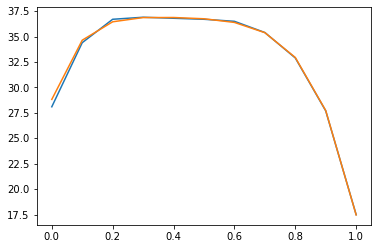

In [49]:
## plotting for comparison
A_est = A.data.numpy()
print(A_est)
p_est = [pressure_eq_np(x_obs[i], A_est[0], A_est[1], p_sat_water, p_sat_dio) for i in range(len(x_obs))]
residual = [p_est[i] - p_obs[i] for i in range(len(p_est))]

plt.plot(x_obs, p_obs)
plt.plot(x_obs, p_est)

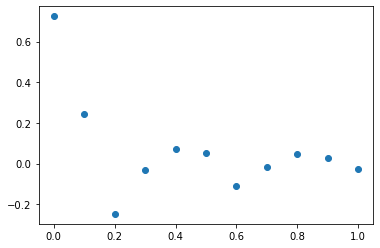

In [51]:
## plotting residuals
plt.scatter(x_obs, residual)

# Problem 2
